# python scratch processing

trying to move analysis over here for greater control, having confirmed basic working in gnuradio.

## imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

## load file

In [8]:
IQ_PATH = "/Users/ebaum/Documents/capstone/iq/"
FILE = "ask-tuned-30k.iq"

SAMP_RATE = 30e3

iq = np.fromfile(os.path.join(IQ_PATH, FILE), np.complex64)

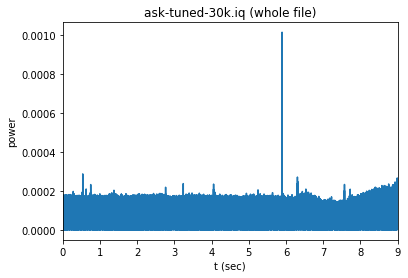

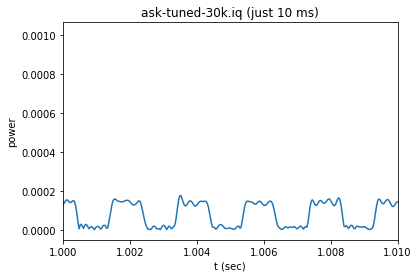

In [165]:
def draw_graph(st=0, et=None):
    max_t = len(iq) // SAMP_RATE
    if et is None:
        et = max_t

    plt.ylabel("power")
    plt.xlabel("t (sec)")
    
    v = np.abs(iq)
    plt.xlim(st, et)
    plt.plot(np.linspace(0, max_t, len(v)), v)

    
plt.title(FILE + " (whole file)")
draw_graph()

plt.figure()
plt.title(FILE + " (just 10 ms)")
draw_graph(1, 1.01)


## demod

I think I'm not *supposed* to, but is there anything I can do with IQ here? Probably some kind of IQ cal, eventually frequency cal, but unclear if worth it

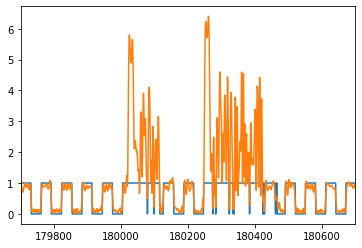

In [246]:
absiq = np.abs(iq)

thresh = np.mean(absiq)
var = np.var(absiq)

# soft decoding: when hit threshold, average pulse value
symb = (absiq > thresh).astype(int)
plt.xlim(179700, 180700)
# plt.ylim(-0.5, 1.5)
plt.plot(symb)
plt.plot(absiq * (thresh/var/3))

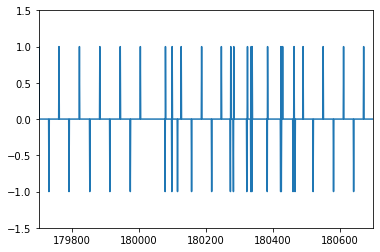

In [243]:
delta = np.diff(symb)

plt.xlim(179700, 180700)
plt.ylim(-1.5, 1.5)
plt.plot(delta)

delta_idx = np.where(delta != 0)[0]

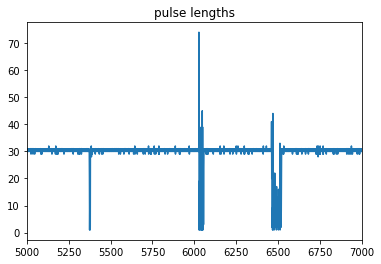

In [238]:
d2 = np.diff(delta_idx)
plt.xlim(5000, 7000)
plt.title("pulse lengths")
plt.plot(d2)

In [247]:
# this is where we had burst errors, i guess.
delta_idx[np.where(d2 > 35)]

array([180004, 180283, 180338, 180384, 192745, 192867, 220502])

## fft
can help estimate carrier freq!

In [88]:
FFT_SIZE = 2048

n_ffts = len(iq) // FFT_SIZE
b = iq[:FFT_SIZE * n_ffts]
chunks = b.reshape((n_ffts, FFT_SIZE))

ffts = []

for c in chunks:
    fft = (np.abs(np.fft.fft(c)) / FFT_SIZE) ** 2
    fft_log = 10 * np.log10(fft)
    fft_shift = np.fft.fftshift(fft_log)
    
    ffts.append(fft_shift)
    
print("generated", len(ffts), "ffts")
print(SAMP_RATE / FFT_SIZE, "ffts per second")

generated 134 ffts
14.6484375 ffts per second


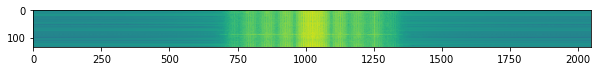

In [91]:
plt.figure(figsize=(10,10))
plt.imshow(ffts[:2000])

est. offset freq 36.62 Hz


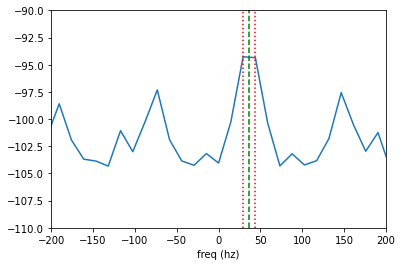

In [194]:
fft_avg = np.mean(ffts, axis=0)
freqs = np.arange(-SAMP_RATE//2, SAMP_RATE//2, SAMP_RATE/FFT_SIZE)
plt.xlabel("freq (hz)")


plt.xlim(-200, 200)
plt.ylim(-110, -90)

max_pts = freqs[np.argmax(fft_avg) + np.array([0, 1])]

plt.plot(freqs, fft_avg)
plt.vlines(max_pts, -110, -90, linestyles='dotted', color='red')

est_offset = np.mean(max_pts)
plt.vlines(est_offset, -110, -90, linestyles='dashed', color='green')

# to get this really accurate - could use a costas loop or something proper
# or take the entire peak waveform, fit a quadratic (?) find peak

print(f"est. offset freq {est_offset:.2f} Hz")



In [192]:
print("peaks of FFT (by bin)")
sorted(enumerate(fft_avg), key=lambda x:-x[1])[:25]

peaks of FFT (by bin)


[(1026, -94.26907724335712),
 (1027, -94.35582309609575),
 (1019, -97.3134750429105),
 (1034, -97.56493347896182),
 (993, -98.34132864650158),
 (1060, -98.48061582953035),
 (1042, -98.53718053608112),
 (1011, -98.59640899686379),
 (1053, -99.15563924209133),
 (1000, -99.18777125301945),
 (1045, -99.46441156929323),
 (1052, -99.49945326297403),
 (1008, -99.53234691417904),
 (1001, -99.85542665692026),
 (992, -100.17386302082602),
 (1025, -100.25038194090898),
 (1018, -100.25502371999416),
 (1028, -100.3421797899344),
 (1035, -100.51793840433447),
 (1253, -100.7618382973651),
 (1061, -100.79121577013976),
 (1016, -101.0678185446225),
 (1037, -101.24201412441319),
 (1044, -101.48390177422264),
 (1009, -101.52045557953254)]